In this notebook we make a classifier that attempts to determine the emotional quality of a speech audio snippet

We're going to use a simple Multilayer Perceptron (MLP) classifier from sklearn to create our model.

I'm going to use the RAVDESS dataset (Ryerson Audio-Visual Database of Emotional Speech and Song dataset), created by Steven Livingstone and Frank Russo of Ryerson University.
See here for more about and to download the RAVDESS dataset: https://smartlaboratory.org/ravdess/ <br>
You can download the dataset used in this notebook at https://zenodo.org/record/1188976 <br>
Scroll half-way down the page and find "Audio_Speech_Actors_01-24" <br>
Here's what we need to know: We're going to use the audio-only speech portion of the RAVDESS dataset, ~200MB.
We get 1440 speech files (24 actors * 60 recordings per actor). Audio is sourced from 24 actors (12 male, 12 female) repeating two sentences in
a variety of emotions and intensity. Each file has been rated  by a human 10 times for emotional quality.

Here's what we're going to do: <br>
1) Load data and split it into test/train sets to enable cross-validation <br>
2) Feature extraction - define the properties which our model will use to evaluate the audio files <br>
3) Train an MLP classifier from sklearn on a train split of the data <br>
4) Check accuracy against a test split of the data <br>


We need a function to extract our features.
We need to know that an audio file can be represented as a time series with the dependent axis being
the amplitude of the audio waveform. The waveform of the sound file is all the information we have with which to create features to train our model.
The shape of a waveform does not carry enough discriminating information, so we need to transform the waveform into a more useable form, pun intended. <br>
![waveform](img/waveform.gif)

The lowest-hanging fruit in time series signal processing is, of course, the Fourier Transform.
Specifically, we'll use the Short-time fourier transform (STFT) which will cut our audio waveform into short, overlapping equal length segments and
take the fourier transform of each segment individually to produce multiple power spectrograms, identifying resonant frequencies present in our audio file. <br>
![stft](img/stft.png)

We're going to build on the STFT by using the Mel Frequency Cepstral Coefficients (MFCC) as a feature.
In brief, MFCC is a mathematical method which gives us coefficients representing amplitudes (in decibels) of pitch from a power spectrum (fourier frequency domain) of an audio signal.
In other words, MFC coefficients give us an idea of the audio intensity in various frequency (and so, pitch) regions.

https://en.wikipedia.org/wiki/Mel-frequency_cepstrum <br>
https://en.wikipedia.org/wiki/Cepstrum <br>
To understound our major feature a little better, we should at least have a vague idea of the math behind it.
So, in a little more detail - MFCC at its core uses a fourier transform (STFT, in particular) to produce an audio power spectrum, which is then mapped to the "mel scale" -
a nonlinear pitch scale representing the perceived pitch (in "mels") of a sound signal w.r.t. its frequency, accounting for the way human
hearing perceives pitch based on frequency ratio rather than absolute differences in frequencies. This mapping of the frequency domain of an audio signal to the mel scale produces a mel spectrogram.
We then take the log of the power at each mel frequency in our spectrogram (we choose the number of mel frequency bins) - producing a cepstrum in the "quefrency" domain - and apply the discrete cosine transform (DCT) to each log power.
Our MFC coefficients are then the magnitude of each frequency bin in our resulting spectrogram.
At the end of the day, we're going to
1) use the STFT to produce audio power spectrograms, <br>
2) apply a mel-scale-based transformation (a triangular window function) to each power spectrogram to produce mel spectrograms, <br>
3) take a log transform of the power of the mel spectrogram to produce a mel-frequency cepstrum (the MFC), <br>
4) and take the discrete cosine transform of the MFC, giving us the MFC coefficients - our measure of power at various mel frequencies (corresponding to pitches). <br>
![mfcc](img/mfcc.gif, width=600, height =600)

To extract an additional feature, we're going to build a chromagram on each power spectrogram computed by STFT. <br>
A chromagram is a representation of an audio signal in the time domain, mapping intensity of an audio signal to a pitch class.
Most often, we map to the 12 pitch classes (i.e. the musical scale CDEFGAB + 5 semitones gives us 12 pitch classes).
https://en.wikipedia.org/wiki/Chroma_feature#Computation_of_audio_chromagrams <br>
![chromagram](chromagam.png)

We're going to take full advantage is librosa, a Python library enabling audio analysis and feature extraction. <br>
Luckily, librosa abstracts away all the math and details of mel spectrorgams, chromagrams, and MFCC. <br>
Although closely related, we're going to take the Mel Spectrogram, MFCC, and chromagrams of each audio file as separate features to try
and have bit more discriminatory power between audio files. <br>
Let's build our feature extraction functions to get a chromagram, a mel spectorgram, and MFC coefficients for each of our audio files.


In [68]:
import librosa
import numpy as np

def feature_chromagram(waveform, sample_rate):
    stft_spectrogram=np.abs(librosa.stft(waveform))
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate).T,axis=0)
    return chromagram

def feature_melspectrogram(waveform, sample_rate):
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate).T,axis=0)
    return melspectrogram

def feature_mfcc(waveform, sample_rate):
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40).T, axis=0)
    return mfc_coefficients

Let's visualize our features to get a better handle on them. <br>
We're going to load one audio file from our dataset, each 3 seconds in length.

In [69]:
import matplotlib.pyplot as plt
import librosa.display
import soundfile
# matplotlib complains about the behaviour of librosa.display, so we'll ignore those warnings:
import warnings; warnings.filterwarnings('ignore')

with soundfile.SoundFile('G:\\Programming\\PyProjects\\Speech Classifier\\RAVDESS dataset\\actor_01\\03-01-01-01-01-01-01.wav') as audio:
    waveform = audio.read(dtype="float32")
    sample_rate = audio.samplerate

Visualize the Power spectrograms output by STFT

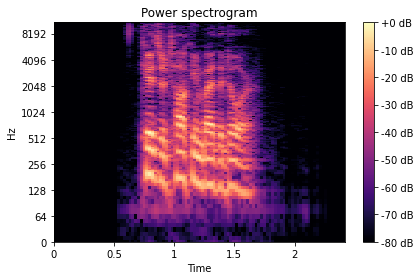

In [70]:
    spectrum_matrix = librosa.stft(waveform)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(spectrum_matrix), ref=np.max),y_axis='log', x_axis='time')
    plt.title('Power spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()

Visualize the chromagram

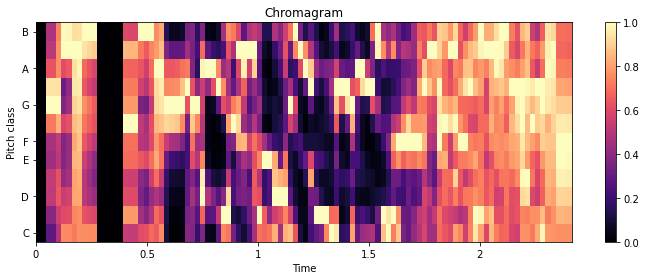

In [71]:
    chromagram = librosa.feature.chroma_stft(y=waveform, sr=sample_rate)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
    plt.colorbar()
    plt.title('Chromagram')
    plt.tight_layout()

Visualize the Mel spectrogram

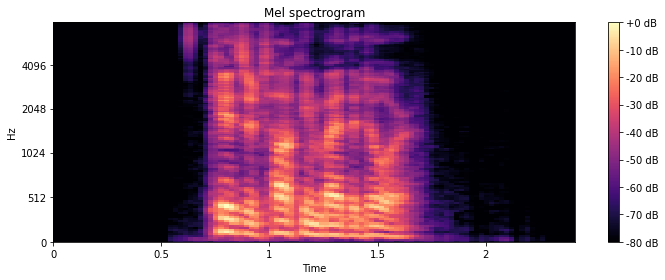

In [72]:
    melspectrogram = librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128, fmax=8000)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(S=melspectrogram, ref=np.max),y_axis='mel',fmax=8000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.tight_layout()

Visualize the series of MFC coefficients

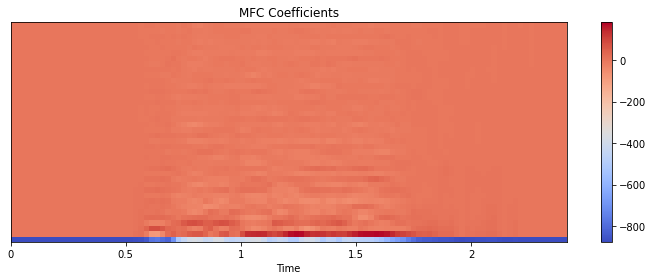

In [73]:
    mfc_coefficients = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfc_coefficients, x_axis='time')
    plt.colorbar()
    plt.title('MFC Coefficients')
    plt.tight_layout()

We're going to wrap our feature extraction functions so we only have to load each audio file once. <br>
After extracting our 3 audio features as NumPy arrays representing a time-series, we're going to
stack them horizontally to create a single feature array.

In [74]:
def get_features(file):
    # load an individual soundfile
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate

        # compute features of soundfile
        chromagram = feature_chromagram(waveform, sample_rate)
        melspectrogram = feature_melspectrogram(waveform, sample_rate)
        mfc_coefficients = feature_mfcc(waveform, sample_rate)

        feature_matrix=np.array([])
        # we're going to use np.hstack to stack our feature arrays horizontally to create a feature matrix
        feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))

        return feature_matrix

Now a little more information about the RAVDESS dataset.
Each file is labelled with 7 numbers delimited by a "-"
Most of the numbers describe metadata about the audio file such as its format (video and/or audio),
whether the audio is a song or statement, which of two statements is being read and by which actor.
The third and fourth numbers pertain to the emotional quality.
The third number is in the range of 1-8 with each number representing an emotion.
The fourth number is either 1 or 2, representing normal (1) or strong (2) emotional intensity.

We're going to define a dictionary based on the third number and assign an emotion to each number as specified by the RAVDESS dataset:

In [75]:
#Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

Finally, let's load our entire dataset and compute the features of each audio file

In [76]:
import os, glob

def load_data():
    x,y=[],[]
    for file in glob.glob("G:\\Programming\\PyProjects\\Speech Classifier\\RAVDESS dataset\\actor_*\\*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        feature=get_features(file)
        x.append(feature)
        y.append(emotion)

    return np.array(x), y

Compute the features and read the emotion labels from our dataset. <br>
Then split the dataset into a train and test split

In [77]:
from sklearn.model_selection import train_test_split

features, emotions = load_data()
x_train,x_test,y_train,y_test=train_test_split(features, emotions, test_size=0.2, random_state=9)

Let's check the shape of the train and test sets, and how many features we have extracted

In [78]:
print((x_train.shape[0], x_test.shape[0]))
print(f'Features extracted: {x_train.shape[1]}')

(1152, 288)
Features extracted: 180


Initialize our Multilayer Perceptron Classifier, train (fit) the model on our training portion of the dataset,
and input our test audio files to predict the emotion:

In [79]:
from sklearn.neural_network import MLPClassifier

model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)
model.fit(x_train,y_train)
y_pred=model.predict(x_test)

Let's check the accuracy of our multilayer perceptron:

In [80]:
from sklearn.metrics import accuracy_score

accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 51.39%


Let's visualize our model's performance:

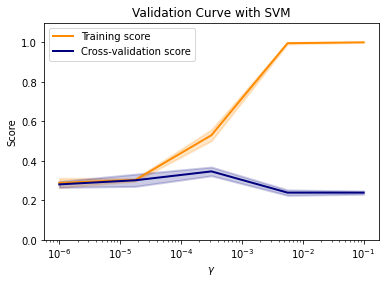

In [81]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve
#plot accuracy
param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    SVC(), x_test, y_pred, param_name="gamma", param_range=param_range,
    scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.title("Validation Curve with SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()


